### 关于图像金字塔
- 要把脸缩到12x12的框内，脸越大需要的倍数也越大
- 语义上缩小的最大倍数，数学上就是乘一个最小的数，所以叫`min_scale`
- 最小缩放倍数就是不需要缩放，也就是1
- 但为了优化，只需要从感兴趣的小脸的倍数开始缩小就可以了，没必要从1开始
- 缩放的时候：
    + 如果按短边缩小，长边就会产生裁切，按长边缩则会有填充，我们选择短边
    
如果小脸30， 大脸100，显然我们只需要从 (12/30=）0.4缩到(12/100=)0.12

In [2]:
def pyrdown(image_size, min_face=12, max_face=0, factor=0.709):
    image_height, image_width = image_size
    short_length = min(image_height, image_width)
    scale        = 1.0  # 原始比率
    scales       = []   # 保存符合条件的缩放
    min_scale    = 12.0 / max_face if max_face != 0 else 0
    max_scale    = 12.0 / min_face
    
    # 第一次缩小，按最小人脸比例（即最大的scale)
    scale *= max_scale
    short_length *= scale
    
    # 以后每次按factor比例缩小
    while short_length >= 12.0 and scale >= min_scale:
        scales.append(scale)
        scale        *= factor
        short_length *= factor # 如果是乘scale的话，就不需要*=，保持short为初值，永远乘最新的scale就行
    
    return scales

pyrdown([1000, 800], 30, 100)

[0.4, 0.2836, 0.2010724, 0.1425603316]

(497, 405, 3)

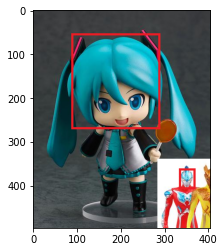

In [5]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
image = cv.imread("miku.png")
plt.imshow(image[...,::-1])
image.shape

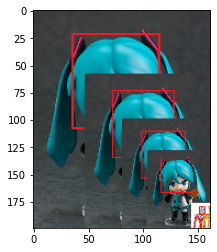

In [36]:
scales = pyrdown(image.shape[:2], 30, 100)
pyrs   = [cv.resize(image, None, fx=scale, fy=scale) for scale in scales]
show   = pyrs[0]
for pyr_image in pyrs[1:]:
    # 排到右下角，小图原点移动：（大图宽度-小图宽度，大图高度-小图高度）
    height, width = pyr_image.shape[:2]
    y, x = show.shape[0] - height, show.shape[1] - width
    show[y:,x:] = pyr_image
plt.imshow(show[...,::-1])

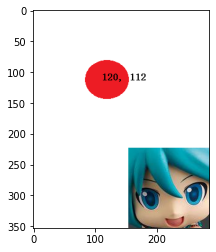

In [24]:
miku = cv.imread('affine.test.png')
def affine_show(M):
    M = M[:2].astype(np.float32)
    show = cv.warpAffine(miku, M, (286, 353))
    plt.imshow(show[...,::-1])
affine_show(np.eye(3))

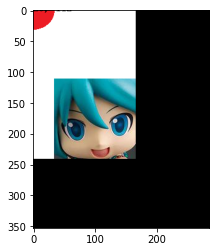

In [25]:
# 想让图片绕红点旋转，就要把红点放到原点去
x, y = 120, 112
T = np.array([
    [1, 0, -x],
    [0, 1, -y], 
    [0, 0, 1]
])
affine_show(T)

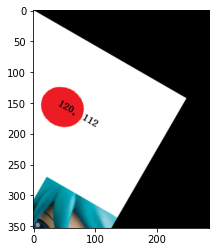

In [26]:
# 顺时针旋转30度（顺逆时针改变两个sin负号位置）
theta = 30 / 180 * np.pi
R = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])
affine_show(R)

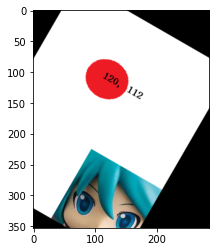

In [27]:
# 再把原点移回去
T2 = np.array([
    [1, 0, x],
    [0, 1, y], 
    [0, 0, 1]
])

affine_show(T2 @ R @ T)

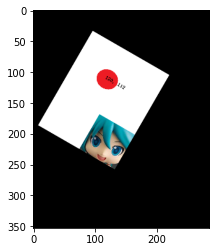

In [29]:
# 加一个scale
S = np.array([
    [0.5, 0, 0],
    [0, 0.5, 0],
    [0, 0, 1]
])
M = T2 @ R @ S @ T
affine_show(M)

In [78]:
M2 = cv.getRotationMatrix2D((x, y), 30, 0.5),
M[:2], M2

(array([[ 0.4330127 , -0.25      , 96.03847577],
        [ 0.25      ,  0.4330127 , 33.50257739]]),
 (array([[ 0.4330127 ,  0.25      , 40.03847577],
         [-0.25      ,  0.4330127 , 93.50257739]]),))

- 原图353 x 286
- 我要将图中人脸抠出来 145 x 140
- 原始位置170 x 244
- 但是抠出来后输出100 x 100的图片

完全的warpAffine方案是这样：
- 将头像左上角移动到图片原点
- 进行缩放，比例100/140，这样140的头像就变成100了
- 可以用dst参数截出100x100，也可以用数组切片截出这100x100了

纯数组方法：
- 对原图根据左上角和宽高进行切片
- 然后要把实际大小和目标大小比例缩放
- 这种取法图片会变形，除非变相处理，比如先建一个纯黑底图，再把抠出来的长方形图居中摆进去

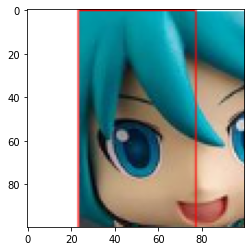

In [262]:
# 需求，抠出半人脸 (170, 244) (145x70)，resize到100x100
# 如果要变成黑底，warpAffine做不到，只能做到roi在100x100的中心，超出部分是原图
# warpAffine 方法：

left, top = 154, 222,
right, bottom = int(left + 70), int(top + 131)
width = right - left
height = bottom - top
miku = cv.imread('affine.test.png')
miku = cv.rectangle(miku, (left, top), (right, bottom), (0, 0, 255), 1)
# plt.imshow(miku[...,::-1])
scale = 100 / max(width, height)  # 对长边缩
dst_size = (100, 100)

c = left + width/2, top + height/2  # 原中心
n = dst_size[0]/2, dst_size[1]/2  # 新中心
x_offset, y_offset = n[0] - scale*c[0], n[1] - scale*c[1]
# 计算偏移可以任意选一点，比如中心，比如左上角
px,py = c
# px = -x_offset
# py = -y_offset

# 失败, 上述a, b, px, py等作用于旋转，公式才那么复杂
# 这里很简单，就是缩放和移动，可以单独设置两组参数
# angle = 0
# theta = (angle / 180) * np.pi
# a = np.cos(theta) * scale
# b = np.sin(theta) * scale

# M = np.array([
#     [a, -b, px*(1-a)-py*b+x_offset],
#     [b, a, px*b+py*(1-a)+y_offset]
# ]).astype(np.float32)
# height, width = miku.shape[:2]
M = np.array([
    [scale, 0, x_offset],
    [0, scale, y_offset]
]).astype(np.float32)

m = cv.warpAffine(miku, M, dst_size)
plt.imshow(m[...,::-1])

(array([123, 163, 197], dtype=uint8), array([125, 117,   0], dtype=uint8))

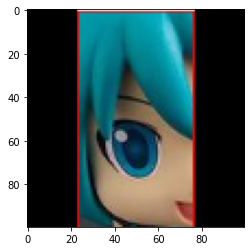

In [282]:
# 数组方法：
# 全脸接近正方形，为了效果明显，取左半边脸试试
# miku = cv.imread('affine.test.png')
left = 154
im = miku[221:, left:left+71]
height, width, _ = im.shape
s = 100/max(height, width)
black = np.zeros((100, 100, 3)).astype(np.uint8)
im = cv.resize(im, None, fx=s, fy=s)
width = im.shape[1]
left = int((100-width)/2)
black[:, left:left+width] = im
plt.imshow(black[..., ::-1])
black[70, 70], im[30, 30]